# 95-865: Interpreting What a Convnet is Learning

This demo is heavily based on Section 5.4 "Visualizing what convnets learn" of Francois Chollet's book *Deep Learning with Python*. I'm only showing two different visualizations here: visualizing outputs of convolutional & max pooling layers, and separately visualizing how much each pixel activates a particular output neuron. The latter is referred to as "class activation maps" (CAMs). It's also possible to visualize the filters themselves (not in this demo). -George H. Chen (georgechen [at symbol] cmu.edu)

We start with some boilerplate imports:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)

## Loading in data

For this demo, we use the [fashion MNIST dataset](https://arxiv.org/abs/1708.07747). The setup is basically identical to MNIST handwritten digits except that instead of 10 different digits, we have 10 different fashion items: t-shirt/tops, trousers, pullovers, dresses, coats, sandals, skirts, sneakers, bags, and ankle boots. We load in the data here:

In [4]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Skirt', 'Sneaker', 'Bag', 'Ankle boot']

## Loading in a Pre-trained Convnet

Next, we load in a pre-trained convnet.

In [5]:
from keras.models import load_model

In [6]:
model = load_model('fashion_mnist_cnn_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                51264     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total para

You can check what the input shape should be:

In [7]:
model.input_shape

(None, 28, 28, 1)

In case you are wondering how we came up with the above pre-trained model, see the code in the cell below (you can uncomment and run it). Note that the convnet architecture below is the same as the one we used in the convnet MNIST handwritten digit demo.

In [6]:
# scaled_train_images = train_images.reshape(len(train_images), train_images.shape[1], train_images.shape[2], -1)
# scaled_test_images = test_images.reshape(len(test_images), test_images.shape[1], test_images.shape[2], -1)
# scaled_train_images = scaled_train_images.astype(np.float32) / 255  # rescale to be between 0 and 1
# scaled_test_images = scaled_test_images.astype(np.float32) / 255  # rescale to be between 0 and 1

# from keras.utils import to_categorical
# train_labels_categorical = to_categorical(train_labels)
# test_labels_categorical = to_categorical(test_labels)

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10, activation='softmax'))
# model.summary()

# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# history = model.fit(scaled_train_images, train_labels_categorical, validation_split=0.2, epochs=5, batch_size=128)
# model.save('fashion_mnist_cnn_model.h5')

## Prediction on a test image

For the rest of this demo, we focus on a single test image:

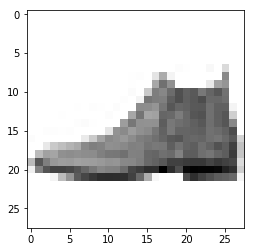

In [8]:
test_image = x_test[0] / 255
plt.imshow(test_image, cmap='binary')

Let's first look at what the pre-trained convnet's prediction is for the test image. First, we convert the test image into a tensor with the same shape as what would go into the convnet. Note that here, the 0th axis will refer to which image we are looking at within a batch (the batch size here is 1 since there is only 1 image):

In [9]:
test_image_tensor = test_image.reshape(1, 28, 28, 1)  # convert test image into a tensor

Let's look at the predicted label probabilities:

In [10]:
test_image_predicted_label_probabilities = model.predict(test_image_tensor)[0]
for idx, prob in enumerate(test_image_predicted_label_probabilities):
    print(labels[idx].ljust(11), ': %.05f' % prob)

T-shirt/top : 0.00000
Trouser     : 0.00000
Pullover    : 0.00000
Dress       : 0.00000
Coat        : 0.00000
Sandal      : 0.00329
Skirt       : 0.00001
Sneaker     : 0.00349
Bag         : 0.00056
Ankle boot  : 0.99264


In [11]:
model.predict(test_image_tensor).shape

(1, 10)

In [12]:
most_probable_label_idx = np.argmax(test_image_predicted_label_probabilities)
print('Most probable label index:', most_probable_label_idx)
print('Most probable label:', labels[most_probable_label_idx])

Most probable label index: 9
Most probable label: Ankle boot


## Visualizing filter outputs

For the specific test image above, let's look at what the outputs are after each of the first four layers (there's a conv2d layer, a max pool layer, another conv2d layer, and another max pool layer; afterward, there are dense layers which are no longer 2D images so while we can visualize these dense 1D vectors, they are harder to interpret).

We begin by specifying a keras `Model` object. This model will take as input a batch of images and output what the outputs are at every layer of the pre-trained convnet. Importantly, this code is treating everything as symbolic variables (so we're not actually plugging in the test image tensor we created in the previous cell yet!).

In [13]:
from keras.models import Model
activation_model = Model(input=model.input,
                         outputs=[layer.output for layer in model.layers])

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("co...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Next, we pass in the test image tensor into the above activation model to get all the layer outputs:

In [14]:
activations = activation_model.predict(test_image_tensor)

For example, we can get the 0th layer's output (this is the first conv2d layer):

In [15]:
activations[0].shape

(1, 26, 26, 32)

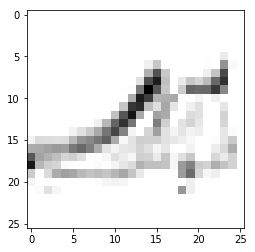

In [16]:
plt.imshow(activations[0][0, :, :, 0], cmap='binary')

I've written a function that plots out everything in a specific layer (note that only layers 0, 1, 2, and 3 correspond to images; after these layers, the representation gets flattened):

In [17]:
def plot_layer_output(layer_idx, num_images_per_row=8):
    if not len(activations[layer_idx].shape) == 4:
        print("Looks like this layer's output doesn't consist of a stack of images?")
    else:
        num_images = activations[layer_idx].shape[-1]

        num_rows = num_images // num_images_per_row
        if num_images % num_images_per_row > 0:
            num_rows += 1

        plt.figure(figsize=(15, 10))
        for image_idx in range(num_images):
            row_idx = image_idx // num_images_per_row
            col_idx = image_idx % num_images_per_row
            plt.subplot(num_rows, num_images_per_row, image_idx + 1)
            plt.imshow(activations[layer_idx][0, :, :, image_idx])

Here's the visualization for the 0-th layer's output. As a reminder, the 0-th layer is a conv2d layer with 32 filters, so there are 32 output images:

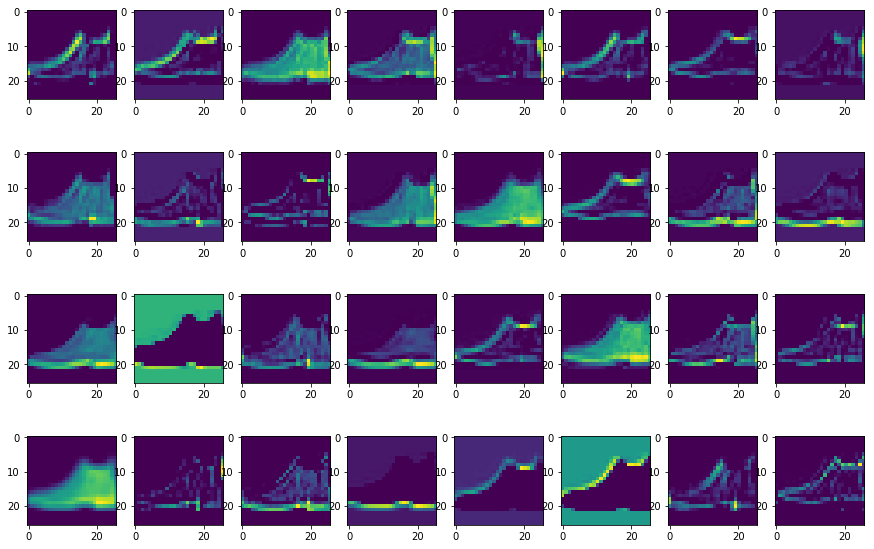

In [18]:
plot_layer_output(0)

Layer 1 is a max pooling layer, so visualizing its output results in what appear to be smaller versions of the 0-th layer's output images:

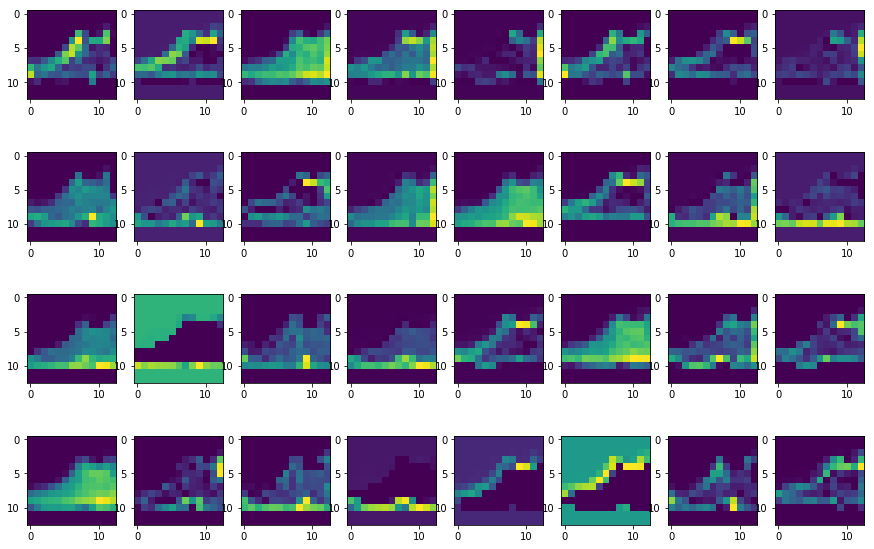

In [19]:
plot_layer_output(1)

The output of layer 2 (the second conv2d layer) is as follows:

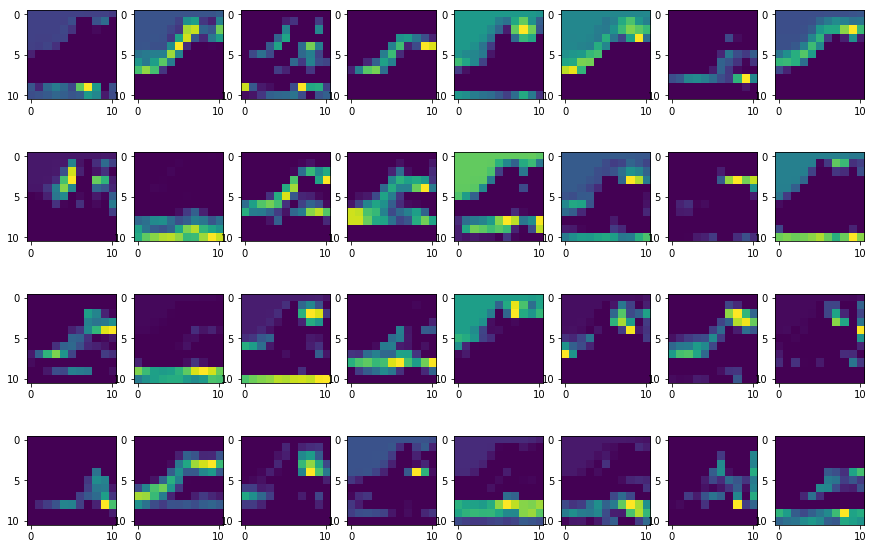

In [20]:
plot_layer_output(2)

We can also get the output of layer 3 (another max pooling):

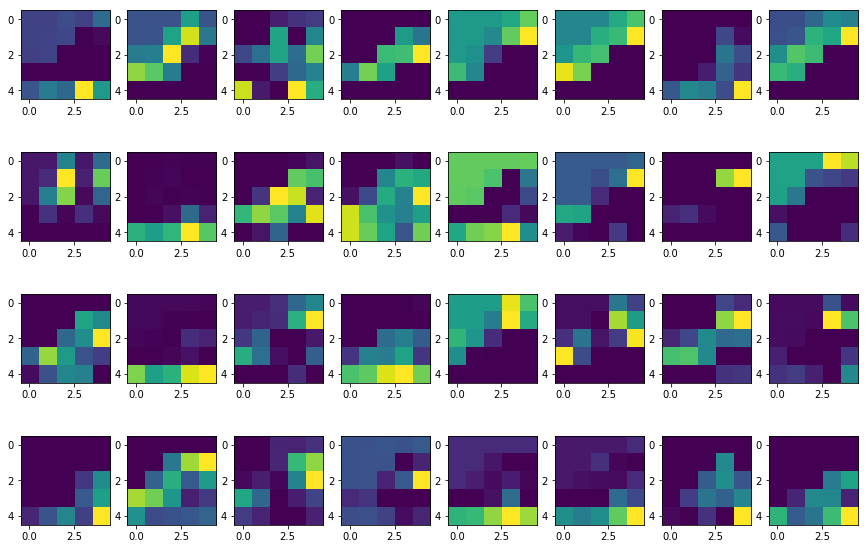

In [21]:
plot_layer_output(3)

What is apparent: the filters are extracting out various edges corresponding to, for instance, the top of the shoe, or the bottom of the shoe, etc.

## Visualizing What Activates the Boot Neuron

Next, I show that we can visualize what drives the activation of the boot neuron. The ankle boot label corresponds to index 9 of the final convnet model's output:

In [22]:
boot_output = model.output[:, 9]

The next cell is a bit more involved. What we are shooting for is to get a heatmap (stored in the variable `heatmap` below) where each pixel in the heatmap says how much that pixel drives the activation of the boot output neuron. In terms of computing how much a pixel matters, we compute a bunch of partial derivatives that involve that pixel and aggregate these partial derivatives in a particular way.

In [23]:
from keras import backend as K

last_conv_layer = model.get_layer('conv2d_2')
gradients = K.gradients(boot_output, last_conv_layer.output)[0]
pooled_gradients = K.mean(gradients, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_gradients, last_conv_layer.output[0]])
pooled_gradient_values, conv_layer_output_values = iterate([test_image_tensor])
for i in range(len(conv_layer_output_values)):
    conv_layer_output_values[:, :, i] *= pooled_gradient_values[i]

heatmap = np.mean(conv_layer_output_values, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= heatmap.max()

When we visualize the heatmap, it's going to look like a low-resolution mess. We shall resize it to be the same size as the original input images (28 by 28).

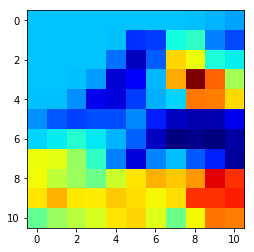

In [24]:
plt.imshow(heatmap, cmap='jet')

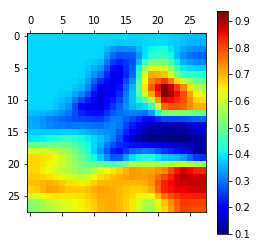

In [26]:
import cv2
heatmap_resized = cv2.resize(heatmap, (28, 28))
plt.matshow(heatmap_resized, cmap='jet')
plt.colorbar()

Note that where the activation is highest is where the foot goes into the shoe, as well as the bottom of the shoe, especially the heel part.

We can superimpose the heatmap over the original test image:

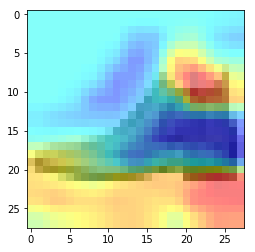

In [27]:
heatmap_jet = np.array(cv2.applyColorMap(((1 - heatmap_resized) * 255).astype(np.uint8), cv2.COLORMAP_JET),
                       dtype=np.float) / 255
superimposed_image = (heatmap_jet * 1.0 + (1 - test_image[:, :, np.newaxis]))
for idx in range(3):
    superimposed_image[:, :, idx] /= superimposed_image[:, :, idx].max()
plt.imshow(superimposed_image)